In [199]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [200]:
RANDOM_SEED = 42

In [201]:
!pip freeze > requirements.txt

In [202]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [203]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [204]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [205]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# **Cleaning and Prepping Data**

In [207]:
#Заполняем пропуски медиальным значением 
df['Number of Reviews']=df['Number of Reviews'].fillna(int(df['Number of Reviews'].mean()))

In [208]:
# Создаем из столбца ID_TA численные значения ID
def IDTA_Uniq(data):
    return int(data[1:])
df['ID_TA']=df['ID_TA'].apply(IDTA_Uniq)

In [209]:
# Считаем количество кохонь в ресторане 
def CountStyle(data):
        count=[]
        for i in range(len(data)):
            if type(data[i])==str:
                count.append(int(len(data[i].split(','))))
        return count
    
df['Cuisine Count']=pd.Series(CountStyle(df['Cuisine Style'])) 
df['Cuisine Count']=df['Cuisine Count'].fillna(int(df['Cuisine Count'].mean()))

In [210]:
# Dummy variables
df = pd.get_dummies(df, columns=['City','Price Range','Cuisine Style'])

In [211]:
# Создаем слобец о количестве отзывов о ресторане 
#def Reviews(data):
#    return len(data.split(','))
#df['Rev']=pd.Series(df['Reviews'].apply(Reviews))

In [212]:
# Убираем столбцы object
df=df.drop(['Reviews','URL_TA','Restaurant_id'],axis=1)

In [213]:
df.sample(10)

,Ranking,Number of Reviews,ID_TA,sample,Rating,Cuisine Count,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,"Cuisine Style_['Wine Bar', 'Italian', 'Mediterranean', 'Greek']","Cuisine Style_['Wine Bar', 'Italian', 'Mediterranean']","Cuisine Style_['Wine Bar', 'Italian', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Italian']","Cuisine Style_['Wine Bar', 'Mediterranean', 'European', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Mediterranean']","Cuisine Style_['Wine Bar', 'Scottish', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Spanish']","Cuisine Style_['Wine Bar', 'Vegetarian Friendly']",Cuisine Style_['Wine Bar']
37070,1935.0,44.0,10150281,1,3.5,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49881,6774.0,9.0,12535525,1,4.5,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29245,626.0,200.0,1516479,1,4.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40942,8480.0,9.0,10819427,1,4.5,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46139,882.0,11.0,9745669,1,4.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37330,8154.0,124.0,13120933,1,5.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41354,3947.0,84.0,4104627,1,4.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8744,5999.0,57.0,7274040,0,0.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14105,2850.0,2.0,12875961,1,4.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5167,7753.0,124.0,12843332,0,0.0,1.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [215]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [216]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 10770), (40000, 10770), (40000, 10769), (32000, 10769), (8000, 10769))

# Model

In [217]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [218]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [219]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [220]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [221]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21908499999999997


# Submission

In [222]:
test_data.sample(10)

,Ranking,Number of Reviews,ID_TA,Rating,Cuisine Count,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,"Cuisine Style_['Wine Bar', 'Italian', 'Mediterranean', 'Greek']","Cuisine Style_['Wine Bar', 'Italian', 'Mediterranean']","Cuisine Style_['Wine Bar', 'Italian', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Italian']","Cuisine Style_['Wine Bar', 'Mediterranean', 'European', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Mediterranean']","Cuisine Style_['Wine Bar', 'Scottish', 'Vegetarian Friendly']","Cuisine Style_['Wine Bar', 'Spanish']","Cuisine Style_['Wine Bar', 'Vegetarian Friendly']",Cuisine Style_['Wine Bar']
475,4429.0,78.0,877381,0.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7006,4701.0,29.0,3431182,0.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9444,1343.0,3.0,10051746,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4018,1303.0,129.0,8122521,0.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5636,4648.0,24.0,11931294,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2454,923.0,474.0,6628567,0.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1646,11183.0,3.0,7274060,0.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4370,12286.0,5.0,901440,0.0,6.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7733,253.0,228.0,3326604,0.0,7.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5787,4428.0,33.0,6698149,0.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


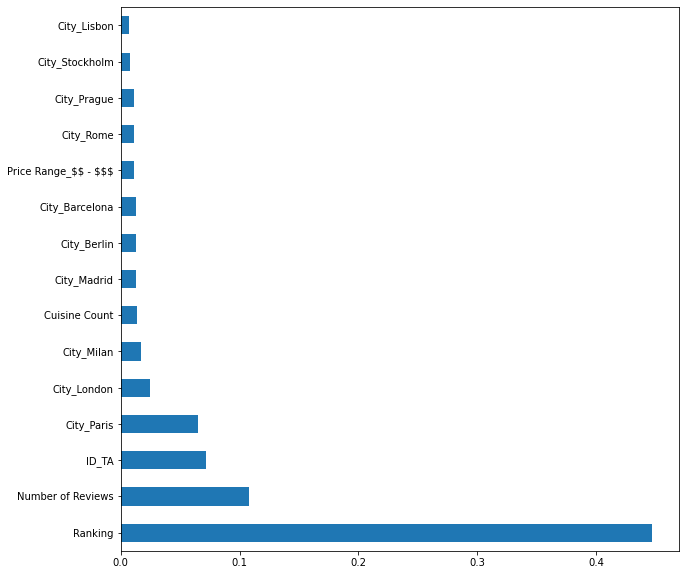

In [223]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [224]:
test_data = test_data.drop(['Rating'], axis=1)

In [225]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [226]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [227]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.280
1,id_1,4.325
2,id_2,4.585
3,id_3,4.230
4,id_4,4.430
5,id_5,4.535
6,id_6,1.750
7,id_7,2.860
8,id_8,4.510
9,id_9,4.430
